In [1]:
import math
import os
from typing import List

import imageio as imageio
import matplotlib.pyplot as plt
import numpy as np

from traj1D import BangBangTrajectory1D, BBTrajectoryPart

In [2]:

max_acc = 3.0
max_vel = 2.5
global_save_figures = False

In [3]:

def get_data_from_part(part: BBTrajectoryPart, t_start=0.0) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    times = np.linspace(t_start, part.t_end, 200)
    acc = np.ones(times.shape) * part.acc
    vel = part.v0 + acc * (times - t_start)
    pos = part.s0 + 0.5 * (part.v0 + vel) * (times - t_start)
    return times, acc, vel, pos


def get_data_from_parts(parts: List[BBTrajectoryPart], t_start=0.0) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    times, acc, vel, pos = None, None, None, None
    t_start_new = t_start
    for part in parts:
        times_new, acc_new, vel_new, pos_new = get_data_from_part(part, t_start=t_start_new)
        t_start_new = part.t_end
        times = np.append(times, times_new) if times is not None else times_new
        acc = np.append(acc, acc_new) if acc is not None else acc_new
        vel = np.append(vel, vel_new) if vel is not None else vel_new
        pos = np.append(pos, pos_new) if pos is not None else pos_new
    return times, acc, vel, pos


def plot(times, acc, vel, pos, title, target_time):
    fig, (ax_p, ax_v, ax_a) = plt.subplots(1, 3, figsize=(20, 5))

    fig.suptitle(title, fontsize=20)

    ax_p.set_ylabel("Position [m]")
    ax_p.set_xlabel("time [s]")
    ax_p.plot(times, pos, color="green")
    ax_p.grid(True)

    ax_v.set_ylim([-max_vel - 0.25, max_vel + 0.25])
    ax_v.set_ylabel("Velocity [m/s]")
    ax_v.set_xlabel("time [s]")
    ax_v.plot(times, vel, color="red")
    ax_v.grid(True)

    ax_a.set_ylim([-max_acc - 0.25, max_acc + 0.25])
    ax_a.set_ylabel("Acceleration [m/s²]")
    ax_a.set_xlabel("time [s]")
    ax_a.plot(times, acc)
    ax_a.grid(True)

    if target_time is not None:
        ax_p.scatter(x=target_time, y=pos[-1], color="red", marker="x", s=20 * 6)
        ax_v.plot([target_time, target_time], [-max_vel - 0.25, max_vel + 0.25], color="gray")
        ax_a.plot([target_time, target_time], [-max_acc - 0.25, max_acc + 0.25], color="gray")

    if global_save_figures:
        plt.savefig(title + ".png")
    plt.show()


def plot_sim_step(times, times_done, times_step, acc, acc_done, acc_step, vel, vel_done, vel_step, pos, pos_done,
                  pos_step, title, target_time):
    fig, (ax_p, ax_v, ax_a) = plt.subplots(1, 3, figsize=(20, 5))

    fig.suptitle(title, fontsize=20)

    ax_p.set_ylabel("Position [m]")
    ax_p.set_xlabel("time [s]")
    ax_p.plot(times, pos, color="gray")
    ax_p.plot(times_done, pos_done, color="black")
    ax_p.plot(times_step, pos_step, color="green")
    ax_p.scatter(x=target_time, y=pos[-1], color="red", marker="x", s=20 * 6)
    ax_p.grid(True)

    ax_v.set_ylim([-max_vel - 0.25, max_vel + 0.25])
    ax_v.set_ylabel("Velocity [m/s]")
    ax_v.set_xlabel("time [s]")
    ax_v.plot(times, vel, color="gray")
    ax_v.plot(times_done, vel_done, color="black")
    ax_v.plot(times_step, vel_step, color="red")
    ax_v.plot([target_time, target_time], [-max_vel - 0.25, max_vel + 0.25], color="gray")
    ax_v.grid(True)

    ax_a.set_ylim([-max_acc - 0.25, max_acc + 0.25])
    ax_a.set_ylabel("Acceleration [m/s²]")
    ax_a.set_xlabel("time [s]")
    ax_a.plot(times, acc, color="gray")
    ax_a.plot(times_done, acc_done, color="black")
    ax_a.plot(times_step, acc_step)
    ax_a.plot([target_time, target_time], [-max_acc - 0.25, max_acc + 0.25], color="gray")
    ax_a.grid(True)

    plt.savefig(title + ".png")
    return title + ".png"


def sim_traj(distance: float, initial_vel: float, target_time: float = None, fallback=False):
    sim_steps = 20
    sim_points = 200
    total_traj = BangBangTrajectory1D()
    total_traj.generate(0, distance, initial_vel, max_vel, max_acc, target_time)
    total_times = np.linspace(0, total_traj.getTotalTime(), sim_points)
    total_pos = [total_traj.getPosition(t) for t in total_times]
    total_vel = [total_traj.getVelocity(t) for t in total_times]
    total_acc = [total_traj.getAcceleration(t) for t in total_times]

    times_done = []
    pos_done = []
    vel_done = []
    acc_done = []

    image_paths = []

    for step in range(sim_steps):
        pos_in_times = int((step + 1) * 200 / 20 - 1)
        current_time = total_times[pos_in_times]
        current_pos = total_pos[pos_in_times]
        current_vel = total_vel[pos_in_times]
        current_acc = total_acc[pos_in_times]
        current_target_time = None if target_time is None else target_time - current_time

        times_done.append(current_time)
        pos_done.append(current_pos)
        vel_done.append(current_vel)
        acc_done.append(current_acc)


        step_times = total_times[pos_in_times:]
        step_traj = BangBangTrajectory1D()
        step_traj.generate(current_pos, distance, current_vel, max_vel, max_acc, current_target_time)

        step_pos = [step_traj.getPosition(t - current_time) for t in step_times]
        step_vel = [step_traj.getVelocity(t - current_time) for t in step_times]
        step_acc = [step_traj.getAcceleration(t - current_time) for t in step_times]

        img_path = plot_sim_step(total_times, times_done, step_times, total_acc, acc_done, step_acc, total_vel, vel_done, step_vel, total_pos, pos_done, step_pos, "{}".format(step), target_time)
        image_paths.append(img_path)

    with imageio.get_writer("Sim d={:.3f} | v={:.3f} | tt={:.3f}.gif".format(distance, initial_vel, target_time), mode="I") as writer:
        for path in image_paths:
            image = imageio.imread(path)
            writer.append_data(image)
    for path in set(image_paths):
        os.remove(path)


def plot_traj(distance: float, initial_vel: float, target_time: float = None, fallback=False):
    traj = BangBangTrajectory1D()
    traj.generate(0, distance, initial_vel, max_vel, max_acc, target_time)
    times = np.linspace(0, traj.getTotalTime(), 200)
    pos = [traj.getPosition(t) for t in times]
    vel = [traj.getVelocity(t) for t in times]
    acc = [traj.getAcceleration(t) for t in times]
    assert math.isclose(pos[-1], distance)
    assert math.isclose(vel[-1], 0.0)
    plot(times, acc, vel, pos, "Traj d={:.3f} | v={:.3f} | tt={:.3f}".format(distance, initial_vel, target_time),
         target_time)


def plot_calc_slowest_direct(distance: float, initial_vel: float, target_time: float = None, fallback=False):
    part = BangBangTrajectory1D.calcSlowestDirect(0, distance, initial_vel, max_acc)
    if part is None:
        if fallback:
            plot_traj(distance, initial_vel, target_time)
        return
    data = get_data_from_parts(part)
    assert math.isclose(data[-1][-1], distance)
    plot(*data, "CalcSlowest d={:.3f} | v={:.3f} | tt={:.3f}".format(distance, initial_vel, target_time), target_time)


def plot_calc_fastest_direct(distance: float, initial_vel: float, target_time: float = None, fallback=False):
    parts = BangBangTrajectory1D.calcFastestDirect(0, distance, initial_vel, max_vel, max_acc)
    data = get_data_from_parts(parts)
    assert math.isclose(data[-1][-1], distance)
    plot(*data, "CalcFastest d={:.3f} | v={:.3f} | tt={:.3f}".format(distance, initial_vel, target_time), target_time)


def plot_calc_fastest_overshot(distance: float, initial_vel: float, target_time: float = None, fallback=False):
    part = BangBangTrajectory1D.calcSlowestDirect(0, distance, initial_vel, max_acc)
    if part is None:
        return
    plot_calc_slowest_direct(distance, initial_vel, target_time, fallback)
    parts = BangBangTrajectory1D.calcFastestOvershot(0, distance, initial_vel, max_vel, max_acc)
    data = get_data_from_parts(parts)
    assert math.isclose(data[-1][-1], distance)
    plot(*data, "CalcFastestOvershot d={:.3f} | v={:.3f} | tt={:.3f}".format(distance, initial_vel, target_time),
         target_time)


def plot_can_reach(distance: float, initial_vel: float, target_time: float = None, fallback=False):
    can_reach, parts, reason = BangBangTrajectory1D.canReach(0, distance, initial_vel, max_vel, max_acc, target_time)
    data = get_data_from_parts(parts)
    assert math.isclose(data[-1][-1], distance)
    plot(*data, "CanReach {} - {} | d={:.3f} | v={:.3f} | tt={:.3f}".format(can_reach, reason, distance, initial_vel,
                                                                            target_time),
         target_time)
    if fallback:
        plot_traj(distance, initial_vel, target_time)

In [6]:

distances = [1]
initial_velocities = [-1, 0, 1]
target_times = [1.0]

for d in sorted(set(distances)):
    for i_v in sorted(set(initial_velocities)):
        for tt in sorted(set(target_times)):
            # plot_traj(d, i_v, target_time=tt, fallback=True)
            pass

sim_traj(1, 1, 1)

NameError: name 'sim_traj' is not defined

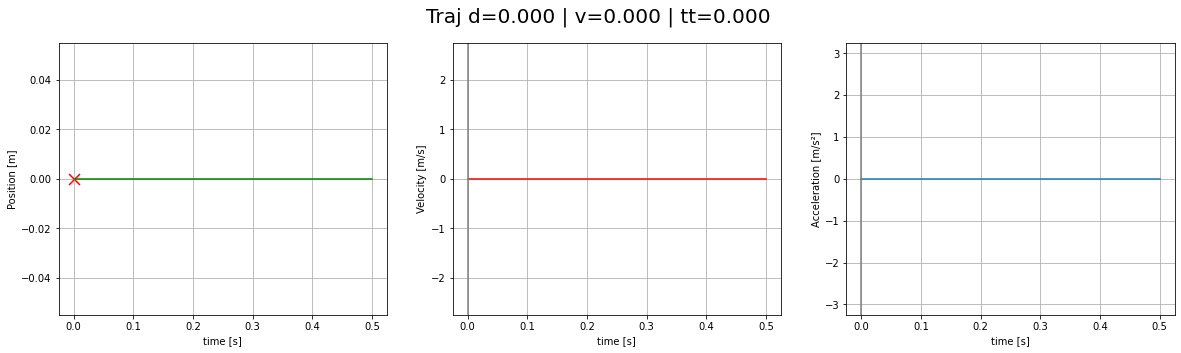

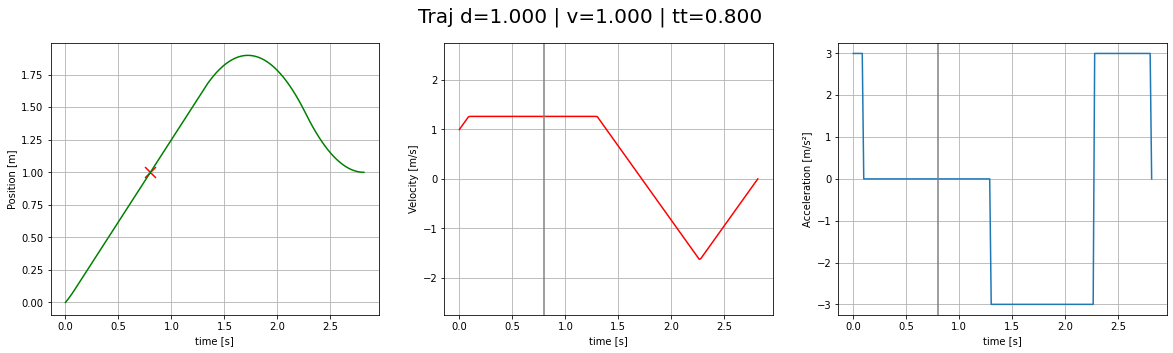

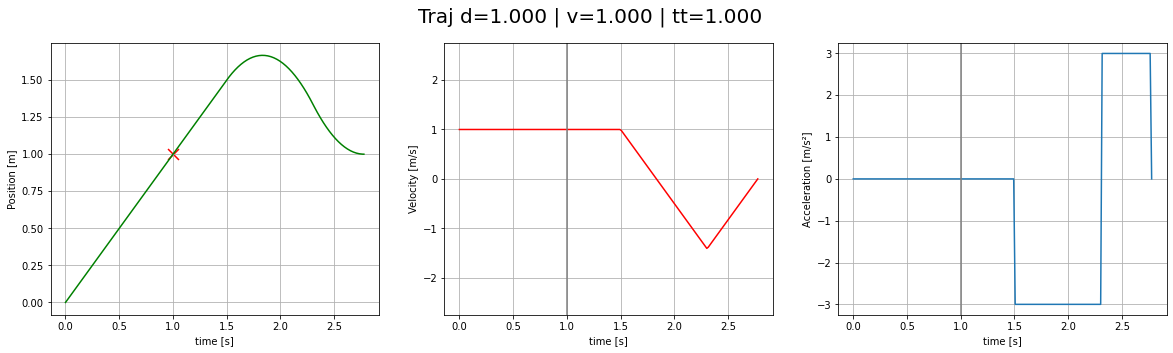

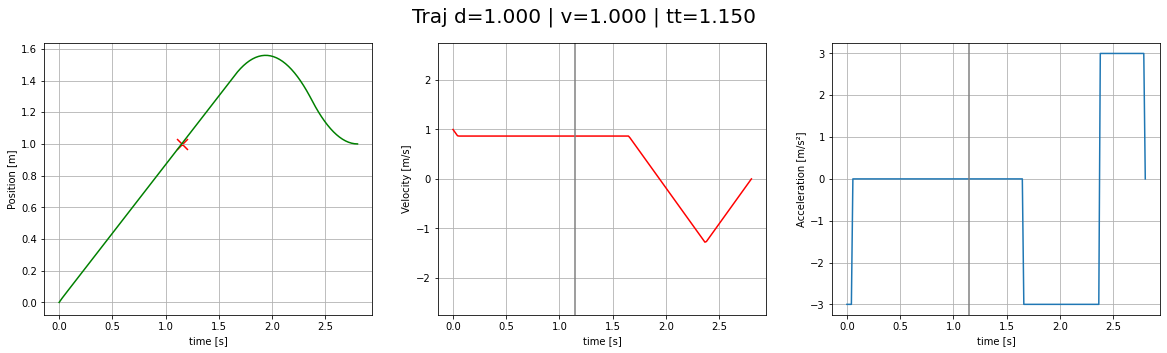

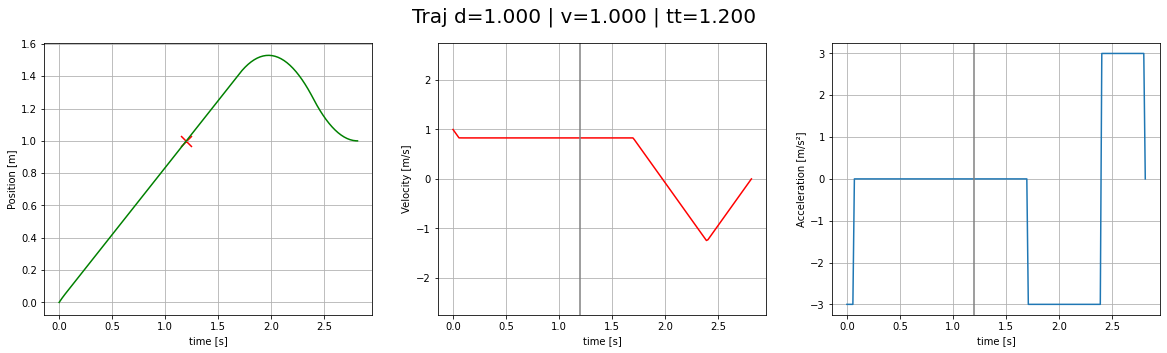

In [5]:
test_values = [
    (0.0, 0.0, 0.0),
    (1.0, 1.0, 0.8),
    (1.0, 1.0, 1.0),
    (1.0, 1.0, 1.15),
    (1.0, 1.0, 1.2),
]

for values in test_values:
    plot_traj(distance=values[0],initial_vel=values[1],target_time=values[2])